In [1]:
!pip install scipy pandas openpyxl

In [10]:
import scipy.io
import pandas as pd
import numpy as np
import os

# Path to the .mat file
mat_file_path = "Battery Data Set/1. BatteryAgingARC-FY08Q4/B0005.mat"

# Load the .mat file
mat_data = scipy.io.loadmat(mat_file_path)

# Extract the 'cycle' data
cycles = mat_data['B0005'][0][0]['cycle'][0]

# We’ll extract only the discharge cycles
records = []

for i, cycle in enumerate(cycles):
    if cycle['type'][0] == 'discharge':
        data = cycle['data'][0, 0]
        
        time = data['Time'].flatten()
        voltage = data['Voltage_measured'].flatten()
        current = data['Current_measured'].flatten()
        temp = data['Temperature_measured'].flatten()
        capacity = data['Capacity'][0, 0] if 'Capacity' in data.dtype.names else None
        
        for t, v, c, temp_val in zip(time, voltage, current, temp):
            records.append({
                'Cycle_Index': i + 1,  # simple cycle number
                'Time (s)': t,
                'Voltage (V)': v,
                'Current (A)': c,
                'Temperature (C)': temp_val,
                'Capacity (Ah)': capacity
            })

# Convert to DataFrame
df = pd.DataFrame(records)

# Sort and clean up
df = df.sort_values(by=['Cycle_Index', 'Time (s)'])

# Output path
output_path_csv = "B0005_discharge_data.csv"

# Export to Excel
df.to_csv(output_path_csv, index=False, encoding='utf-8')

print(f"✅ Data exported successfully to '{output_path_csv}'")

✅ Data exported successfully to 'B0005_discharge_data.csv'


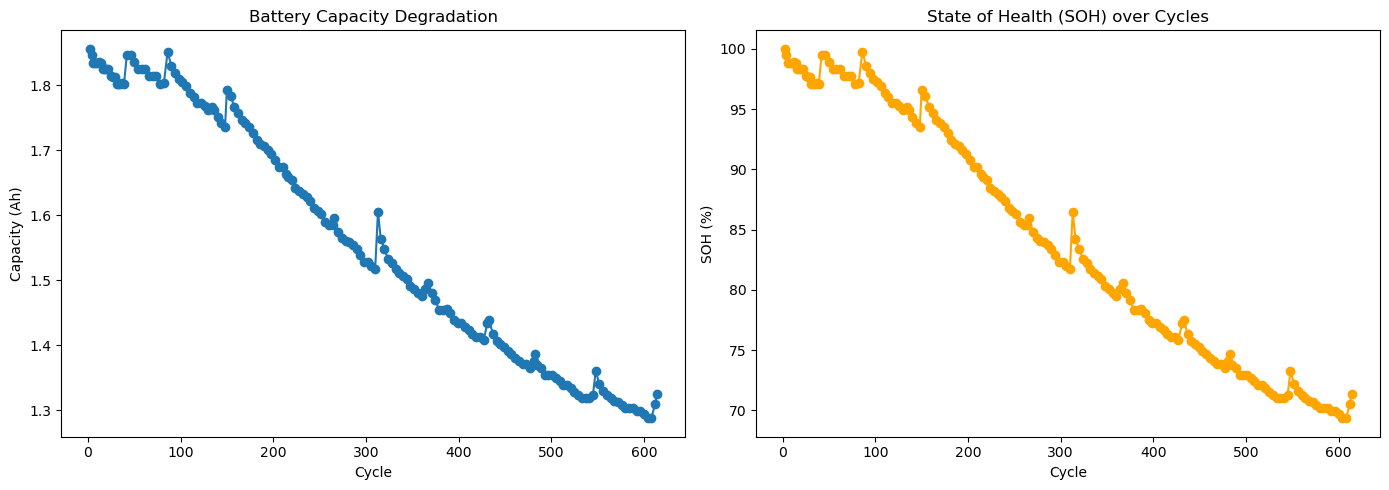

✅ Cycle summary exported successfully to 'B0005_cycle_summary.csv'


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the previously saved CSV
df = pd.read_csv("B0005_discharge_data.csv")

# Step 1: Clean data (remove zero or negative capacity values)
df = df[df['Capacity (Ah)'] > 0]

# Step 2: Group by cycle and extract summary features
cycle_summary = df.groupby('Cycle_Index').agg({
    'Voltage (V)': ['min', 'max'],
    'Temperature (C)': 'mean',
    'Capacity (Ah)': 'first'  # Same for all rows in a cycle
})

# Flatten column names
cycle_summary.columns = ['Voltage_Min', 'Voltage_Max', 'Temperature_Avg', 'Capacity']

# Step 3: Calculate SoH (based on initial capacity, usually around 2.0 Ah)
initial_capacity = cycle_summary['Capacity'].iloc[0]
cycle_summary['SOH (%)'] = (cycle_summary['Capacity'] / initial_capacity) * 100

# Reset index so Cycle_Index becomes a column again
cycle_summary = cycle_summary.reset_index()

# Step 4: Visualizations
plt.figure(figsize=(14, 5))

# Capacity degradation curve
plt.subplot(1, 2, 1)
plt.plot(cycle_summary['Cycle_Index'], cycle_summary['Capacity'], marker='o')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.title('Battery Capacity Degradation')

# SOH curve
plt.subplot(1, 2, 2)
plt.plot(cycle_summary['Cycle_Index'], cycle_summary['SOH (%)'], marker='o', color='orange')
plt.xlabel('Cycle')
plt.ylabel('SOH (%)')
plt.title('State of Health (SOH) over Cycles')

plt.tight_layout()
plt.show()

# Step 5: Save processed data
output_summary_csv = "B0005_cycle_summary.csv"
cycle_summary.to_csv(output_summary_csv, index=False)

print(f"✅ Cycle summary exported successfully to '{output_summary_csv}'")